In [ ]:
import sklearn 
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# for SVM 
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.decomposition import PCA



# viola jones 
import cv2 as cv
import scipy
import math
import PIL
from PIL import Image
import pandas as pd

# dlib detector 
import dlib
from google.colab.patches import cv2_imshow

In [ ]:
from collections import Counter
with open('/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/labels.csv', 'r') as d:
  lines = d.readlines()[1:]
  gender_list = []
  for line in lines:
    gender = line.split()[2]
    gender_list.append(gender)

  print(Counter(gender_list).values())
  print(Counter(gender_list).keys())

## Support vector machine classification 

In [ ]:
def get_data():

  X,y = lab2_landmarks.extract_features_labels()
  y_1 = y.astype('int64')

  X_1 = X.reshape((X.shape[0], X.shape[1]* X.shape[2]))

  x_train = X_1[:100]
  y_train = y_1[:100]
  x_test = X_1[100:]
  y_test = y_1[100:]

  return x_train, y_train, x_test, y_test

def model_training(model, x_train, y_train, x_test):

  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)

  return y_pred

def calculate_results(y_pred, y_test):

  accu = accuracy_score(y_test, y_pred)
  results = classification_report(y_test, y_pred)

  return accu, results 



# SVM linear kernel 

In [ ]:
x_train, y_train, x_test, y_test = get_data()
model = SVC(kernel = 'linear', C = 1.0)
y_pred = model_training(model, x_train, y_train, x_test)
accu, _ = calculate_results(y_pred, y_test)

## SVC linear 

In [ ]:
x_train, y_train, x_test, y_test = get_data()
model = LinearSVC(C = 1.0)
y_pred = model_training(model, x_train, y_train, x_test)
accu, _ = calculate_results(y_pred, y_test)

In [ ]:
print(' the accuracy of this Linear SVC is {}%'.format(accu*100))
results = classification_report(y_test, y_pred)
print(results)

## SVM rbf kernels

In [ ]:

model_1 = SVC(kernel = 'rbf', C = 1.0, gamma = 'scale')
y_pred = model_training(model_1, x_train, y_train, x_test)
accu, _ = calculate_results(y_pred, y_test)
print(' the accuracy of the rbf kernel is {}%'.format(accu *100))


## Poly kernel

In [ ]:
x_train, y_train, x_test, y_test = get_data()
model_2 = SVC(kernel = 'poly', C = 1.0, degree = 3)
y_pred = model_training(model_2, x_train, y_train, x_test)
accu, _ = calculate_results(y_pred, y_test)

In [ ]:
print(' the accurayc of the polynomial kernel SVM is {}'.format(accu *100))
results = classification_report(y_test, y_pred)

 the accurayc of the polynomial kernel SVM is 91.66666666666666


## Haar cascade with face alignment

In [ ]:
def euclidean_distance(a, b):
  x1 = a[0]; y1 = a[1]
  x2 = b[0]; y2 = b[1]
  return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

In [ ]:
# load image
base_path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/img'
images_list = os.listdir(base_path)
image_path = os.path.join(base_path, images_list[7])
image_1 = cv.imread(image_path)
image_1_copy = image_1.copy()
gray_image = cv.cvtColor(image_1, cv.COLOR_RGB2GRAY)

# define the haar classifier
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
eyes_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye.xml')

# detect faces and focus in the region of interest 
detected_faces = face_cascade.detectMultiScale(gray_image, scaleFactor = 1.1, minNeighbors = 5)
column, row, width, height = detected_faces[0]
resized_image = image_1[row: row + height, column: column+ width]
resized_gray = cv.cvtColor(resized_image, cv.COLOR_RGB2GRAY)

# # detect eyes in region of interest 
detected_eyes = eyes_cascade.detectMultiScale(resized_gray, scaleFactor = 1.1, minNeighbors = 5)
print(len(detected_eyes))
#face realignment 
index = 0
for count, (eye_x, eye_y, eye_w, eye_h) in enumerate(detected_eyes):
  if index == 0:
    eye_1 = (eye_x, eye_y, eye_w, eye_h)
  elif index == 1:
    eye_2 = (eye_x, eye_y, eye_w, eye_h)
  index = index + 1

if eye_1[0] < eye_2[0]:
  left_eye = eye_1
  right_eye = eye_2
else:
  left_eye = eye_2
  right_eye = eye_1

# get the centers o the yes for face realignment 

left_eye_center_x = int(left_eye[0] + left_eye[2]/2)
left_eye_center_y = int(left_eye[1] + left_eye[3]/2)
right_eye_center_x = int(right_eye[0] + right_eye[2]/2)
right_eye_center_y = int(right_eye[1] + right_eye[3]/2)
  
cv.circle(resized_image, (left_eye_center_x, left_eye_center_y), 1, (255,0,0), 1)
cv.circle(resized_image, (right_eye_center_x, right_eye_center_y), 1, (255,0,0), 1)
cv.line(resized_image, (left_eye_center_x, left_eye_center_y), (right_eye_center_x, right_eye_center_y),
        (67,67,67), 1)

plt.figure(figsize = (20,8))
plt.imshow(resized_image)

# finding the angle of rotation 
rotation_angle = None
third_point = None

if left_eye[1] > right_eye[1]:
  print('This image is being rotated anti-clockise')
  rotation_angle = 1
  third_point = (left_eye[0], right_eye[1])
  dist_a = euclidean_distance((left_eye_center_x, left_eye_center_y), 
                          (right_eye_center_x,right_eye_center_y))
  dist_b = euclidean_distance((left_eye[0],left_eye[1]), third_point)
  dist_c = euclidean_distance((right_eye[0], right_eye[1]), third_point)
else:
  print('this image is being rotated clockwise')
  rotation_angle = -1
  third_point = (right_eye[0], left_eye[1])
  dist_a = euclidean_distance((left_eye_center_x, left_eye_center_y), 
                              (right_eye_center_x,right_eye_center_y))
  dist_b = euclidean_distance((right_eye[0],right_eye[1]), third_point)
  dist_c = euclidean_distance((left_eye[0], left_eye[1]), third_point)


# apply cosine rule 

cos_a = (dist_b*dist_b + dist_c*dist_c - dist_a*dist_a)/(2*dist_b*dist_c)
angle = np.arccos(cos_a)
angle = (angle * 180) / math.pi

if rotation_angle == -1:
  angle = 90 - angle 
new_img = Image.fromarray(image_1)
new_img = np.array(new_img.rotate(rotation_angle* angle))


plt.figure(figsize = (20,8))
plt.imshow(new_img)

plt.figure(figsize = (20,8))
plt.imshow(image_1_copy)

## Final trails 

In [ ]:
def face_detector(counter, image_1, output_path):

  # convert to grayscale image 
  gray_image = cv.cvtColor(image_1, cv.COLOR_RGB2GRAY)

  face_detect = dlib.get_frontal_face_detector()
  # detect faces
  detected_faces = face_detect(gray_image)

  if len(detected_faces) == 0:
    print('No frontal faces were found in the image number {}'.format(counter))
    return False 

  else:
    face_area_dict = {}
    for counter, rect in enumerate(detected_faces):
      
      column = rect.left()
      row = rect.top()
      width  = rect.right() - column
      height = rect.bottom() - row

      area = width * height 
      face_area_dict[area] = (column, row, width, height)

    max_area = max(face_area_dict.keys())
    x, y, w, h = face_area_dict[max_area]
    resized_image = image_1[y: y+h, x: x+w]
    resampled_image = cv.resize(resized_image, (80,80), cv.INTER_CUBIC)
    resized_gray = cv.cvtColor(resampled_image, cv.COLOR_RGB2GRAY)

    cv.imwrite(output_path, resized_gray)
    return True

def process_images(base_file, output_dir, labels_path, l_out, sample_size):

  base_file = base_file 
  output_dir = output_dir
  
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  list_ims = sorted(os.listdir(base_file))

  for counter, img in enumerate(list_ims[sample_size: 2*sample_size]):
    if counter > sample_size:
      print('Reached the end of the sample size')
      break
    else:
      print('processing image number {} with name {}'.format(counter, img))
      im = cv.imread(os.path.join(base_file, img))
      output_path = os.path.join(output_dir, img)
      result = face_detector(counter, im, output_path)
      if result:
        with open(labels_path, 'r') as d:
          with open(l_out, 'a') as f:
            lines = d.readlines()[1:]
            for line in lines:
              file_name = line.split('/')[0].split()[1]
              if file_name == img:
                f.write(line)
                break
              else:
                continue

      else:
        continue 
 
def get_data_2(path_x, path_y, sm = False):

  # x dataset
  list_images = os.listdir(path_x)

  X_data = [np.reshape(cv.imread(os.path.join(path_x, i), cv.IMREAD_GRAYSCALE)/255, (80*80,)) for i in list_images]
  x_out = np.asarray(X_data)


  # y dataset 
  columns = ['Image number', 'file name', 'Gender', 'smiling']
  y_data = pd.read_csv(path_y, delimiter = '\t', header = None, names = columns)
  y_out = np.asarray(y_data['Gender'])
  y_out_m = np.asarray(y_data['smiling'])

  x_train, x_test, y_train, y_test = train_test_split(x_out[:1440], y_out, test_size = 0.3, shuffle = True) 

  return x_train, x_test, y_train, y_test

def get_validation_set(x_train, y_train):

  x_train_1, x_val, y_train_1, y_val = train_test_split(x_train, y_train, test_size = 0.3, shuffle = 0.3)

  return x_train_1, x_val, y_train_1, y_val

In [ ]:
base = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/img'
out =  '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/A1 datasets/celeba(80 by 80)(trial)'
labels_path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/labels.csv'
l_out = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/A1 datasets/labels(80 by 80)(trial).csv'
process_images(base, out, labels_path, l_out, 1500)

In [ ]:
# apply SVM to the large images with 
path_x = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba(80 by 80)(large)'
path_y = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/labels_2(80 by 80)(large).csv'
x_train, x_test, y_train, y_test = get_data_2(path_x, path_y, sm = False)
x_train_1, x_val, y_train_1, y_val = get_validation_set(x_train, y_train)

## Experiments

In [ ]:
# apply principle component analysis 

def face_detector_2(image):

  gray_scale = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
  faces_pca = PCA(n_components = 0.8)
  faces_pca.fit(gray_scale)

  return gray_scale

path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/img'
images = sorted(os.listdir('/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/img'))

img = cv.imread(os.path.join(path,images[5]))
gray_scale = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
faces_pca = PCA(n_components = 21)
resized_image = faces_pca.fit_transform(gray_scale)


plt.figure(figsize = (20,8))
plt.imshow(resized_image, cmap ='gray')

## Hyper parameter selection 

In [ ]:
mod = SVC()
mod.fit(x_train, y_train)
y_pred = mod.predict(x_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.66      1.00      0.79       593
           1       0.99      0.27      0.42       415

    accuracy                           0.70      1008
   macro avg       0.83      0.63      0.61      1008
weighted avg       0.80      0.70      0.64      1008



In [ ]:
# C paramter, kernel and gama optimization ubsing grid search
# with 5 fold cross validation 

param_grid = {'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']} 

grid = GridSearchCV(mod, param_grid, refit = True, verbose = 3, scoring = 'accuracy')


# fitting the model for grid search
grid.fit(x_val, y_val)
allscores= grid.cv_results_['mean_test_score']
print(allscores)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.557 total time=   0.3s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.557 total time=   0.3s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.557 total time=   0.3s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.567 total time=   0.3s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.567 total time=   0.4s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.508 total time=   0.3s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.639 total time=   0.3s
[CV 3/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.492 total time=   0.2s
[CV 4/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.500 total time=   0.2s
[CV 5/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.517 total time=   0.2s
[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.557 total time=   0.2s
[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid

In [ ]:
print(grid.best_params_)

{'C': 1.5, 'gamma': 'scale', 'kernel': 'sigmoid'}


In [ ]:
param_grid_2 = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5]}
model_1 = SVC(kernel = 'sigmoid', gamma = 'scale')
grid_2 = GridSearchCV(model_1, param_grid_2, refit = True, verbose = 3, scoring = 'accuracy')
grid_2.fit(x_val, y_val)
allscores= grid_2.cv_results_['mean_test_score']
print(allscores)


Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END .............................C=0.1;, score=0.557 total time=   0.2s
[CV 2/5] END .............................C=0.1;, score=0.557 total time=   0.2s
[CV 3/5] END .............................C=0.1;, score=0.557 total time=   0.3s
[CV 4/5] END .............................C=0.1;, score=0.567 total time=   0.5s
[CV 5/5] END .............................C=0.1;, score=0.567 total time=   0.5s
[CV 1/5] END .............................C=0.2;, score=0.557 total time=   0.5s
[CV 2/5] END .............................C=0.2;, score=0.557 total time=   0.4s
[CV 3/5] END .............................C=0.2;, score=0.557 total time=   0.2s
[CV 4/5] END .............................C=0.2;, score=0.567 total time=   0.3s
[CV 5/5] END .............................C=0.2;, score=0.567 total time=   0.3s
[CV 1/5] END .............................C=0.3;, score=0.557 total time=   0.3s
[CV 2/5] END .............................C=0.3;

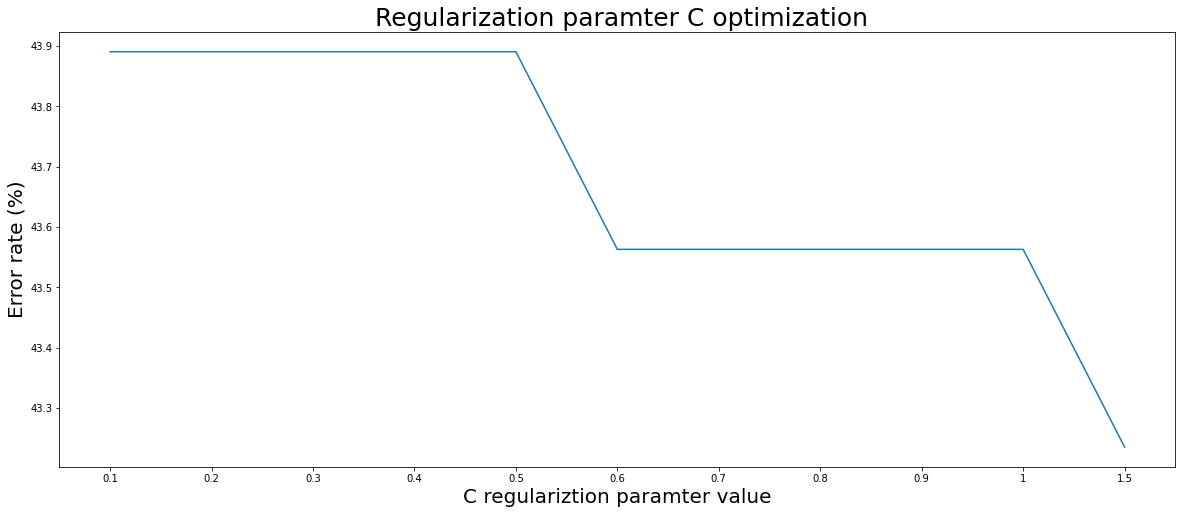

In [ ]:
C_params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5]
error_rates = [ (1-i)*100 for i in allscores]
plt.figure(figsize = (20,8))
plt.title(' Regularization paramter C optimization', fontsize = 25)
plt.xlabel('C regulariztion paramter value', fontsize = 20)
plt.ylabel('Error rate (%)', fontsize = 20)
plt.xticks(np.arange(11),C_params)
plt.plot(error_rates)

In [ ]:
model_1.fit(x_train, y_train)
y_pred_train = model_1.predict(x_train)
print(classification_report(y_train, y_pred_train))


              precision    recall  f1-score   support

          -1       0.66      1.00      0.80       590
           1       1.00      0.27      0.43       418

    accuracy                           0.70      1008
   macro avg       0.83      0.64      0.61      1008
weighted avg       0.80      0.70      0.64      1008



In [ ]:
# Testing dataset
y_pred_test = model_1.predict(x_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.58      0.98      0.73       251
           1       0.54      0.04      0.07       181

    accuracy                           0.58       432
   macro avg       0.56      0.51      0.40       432
weighted avg       0.57      0.58      0.46       432



In [ ]:
# employ cross validation for the C paramer and then the kernel selection 
# linear kernel 
C = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
model = SVC(kernel='rbf', gamma)
scores = cross_val_score(model,x_train, y_train, cv=5)
print(scores)

[0.49009901 0.53465347 0.52970297 0.50746269 0.56716418]


In [ ]:
# rbf kernel cros validation 

C = 1.0
model_1 = SVC(kernel='rbf', C=C)
scores_1 = cross_val_score(model_1,x_train, y_train, cv=5)
print(scores_1)

[0.54455446 0.57425743 0.57920792 0.60199005 0.5721393 ]


In [ ]:

# poly kenerl cross validation 

C = 1.0
model_2= SVC(kernel='poly', C=C)
scores_2 = cross_val_score(model_2,x_train, y_train, cv=5)
print(scores_2)


[0.51980198 0.4950495  0.5049505  0.55721393 0.52238806]


In [ ]:
print(grid.best_params_)

{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
